In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [4]:
import warnings
warnings.filterwarnings(action='ignore')
from matplotlib import rc   #한글폰트 안깨지게 하려고
rc('font',family='Malgun Gothic')  #한글 폰트 설정
rc('axes',unicode_minus=False)

In [463]:
#csv 파일 읽어오기
train = pd.read_csv('Dcon/open/train.csv')
test = pd.read_csv('Dcon/open/test.csv')

In [464]:
train.info()  # train 데이터 확인 --> 배터리 용량에 결측치가 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [35]:
test.info()  #test 데이터도 똑같이 배터리용량에 결측치가 존재

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 846 entries, 0 to 845
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        846 non-null    object 
 1   제조사       846 non-null    object 
 2   모델        846 non-null    object 
 3   차량상태      846 non-null    object 
 4   배터리용량     542 non-null    float64
 5   구동방식      846 non-null    object 
 6   주행거리(km)  846 non-null    int64  
 7   보증기간(년)   846 non-null    int64  
 8   사고이력      846 non-null    object 
 9   연식(년)     846 non-null    int64  
dtypes: float64(1), int64(3), object(6)
memory usage: 66.2+ KB


In [471]:
#컬럼명을 간단하게 변경
train.columns = ['ID','제조사','모델','차량상태','배터리용량','구동방식','주행거리','보증기간','사고이력','연식','가격']
test.columns = ['ID','제조사','모델','차량상태','배터리용량','구동방식','주행거리','보증기간','사고이력','연식']

In [465]:
train.describe()  #값 범위 확인

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
count,4786.000000,7497.000000,7497.000000,7497.000000,7497.000000
mean,69.397187,44287.979458,4.960918,0.222489,62.331949
std,15.283635,55204.064386,3.155342,0.569232,36.646759
min,46.000000,3.000000,0.000000,0.000000,9.000000
25%,56.359000,5465.000000,2.000000,0.000000,34.390000
50%,68.125000,17331.000000,5.000000,0.000000,56.000000
75%,78.227000,61252.000000,8.000000,0.000000,80.050000
max,99.800000,199827.000000,10.000000,2.000000,161.090000


In [38]:
test.describe()

,배터리용량,주행거리,보증기간,연식
count,542.000000,846.000000,846.000000,846.000000
mean,69.712963,44664.152482,5.027187,0.206856
std,15.078398,55518.084064,3.157479,0.544798
min,46.000000,2.000000,0.000000,0.000000
25%,56.623000,6156.500000,2.000000,0.000000
50%,68.479000,17254.000000,5.000000,0.000000
75%,78.035250,60141.250000,8.000000,0.000000
max,99.800000,199948.000000,10.000000,2.000000


In [467]:
#이상치 값을 확인하고 싶어서
train_show = list(train.describe().columns)

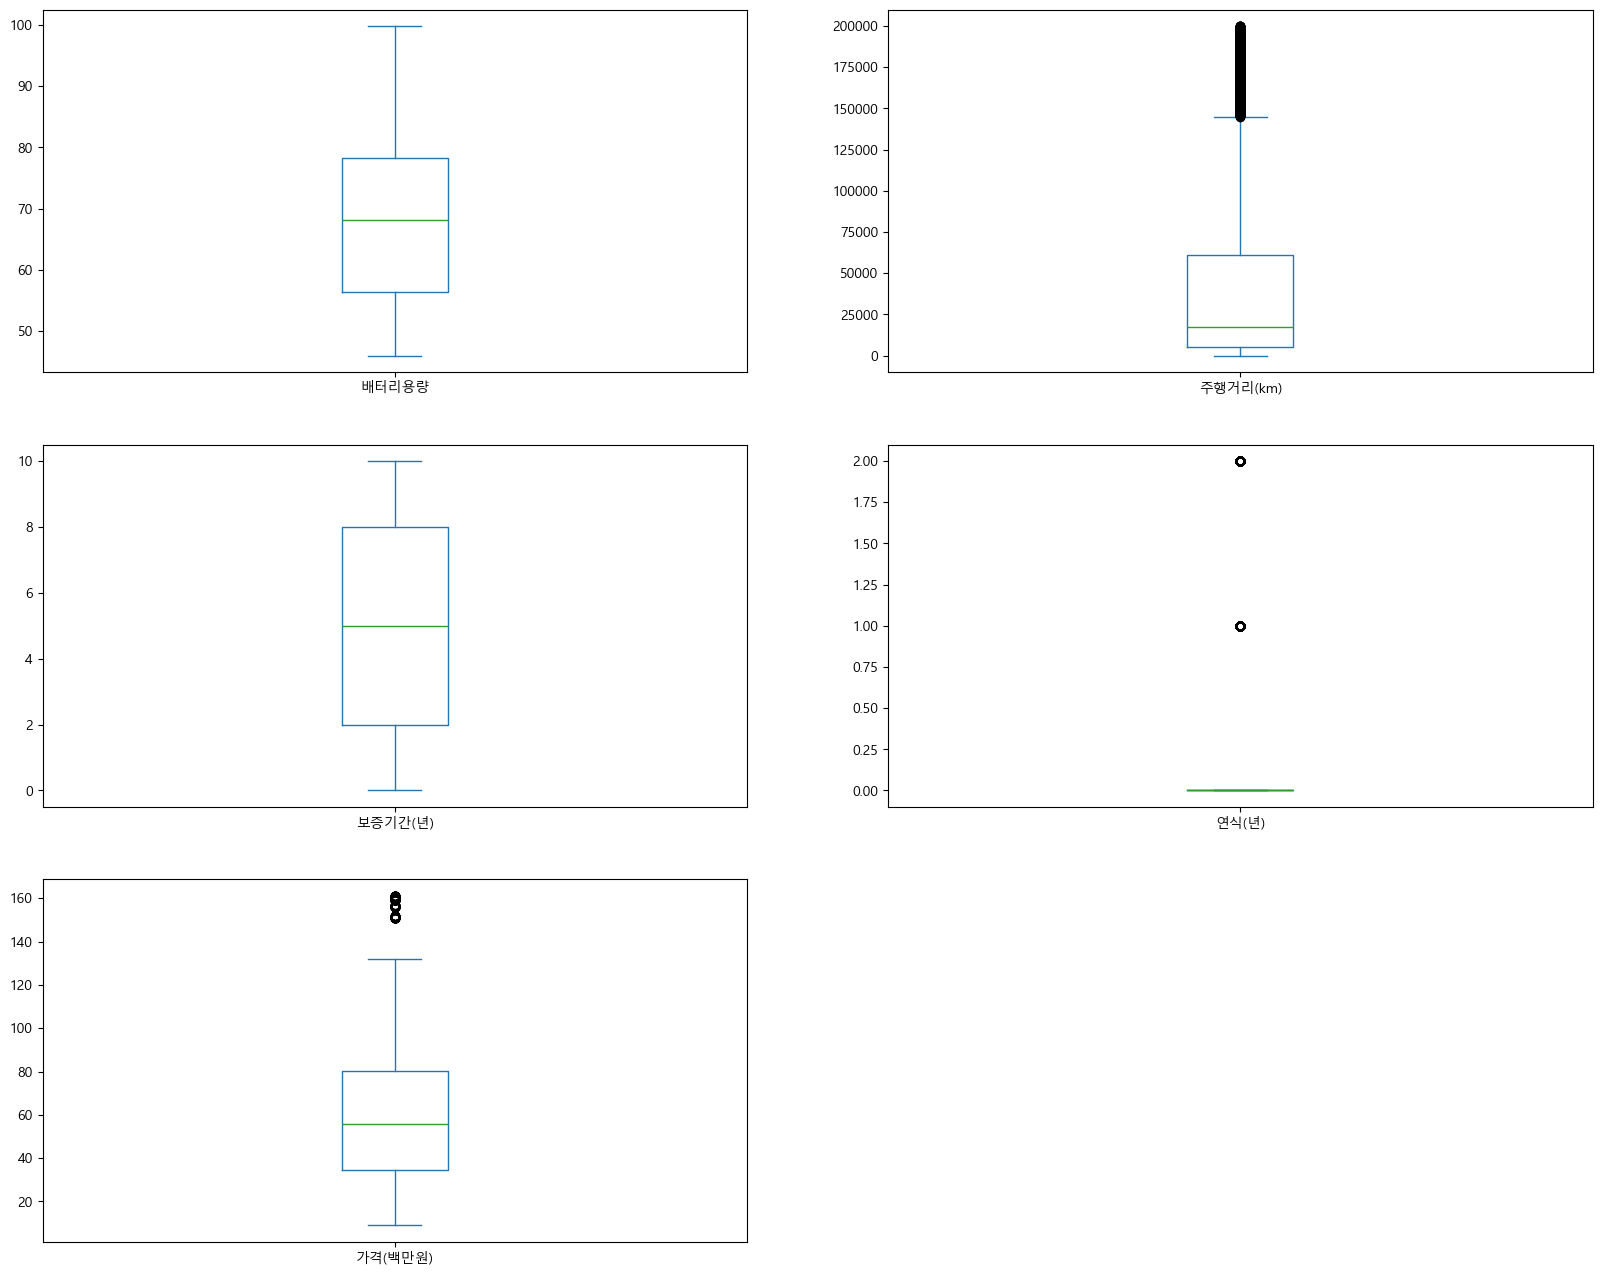

In [468]:
plt.figure(figsize=(20,16))
j = 1
for i in train_show:
    plt.subplot(3,2,j)
    train[i].plot(kind='box')
    j += 1;

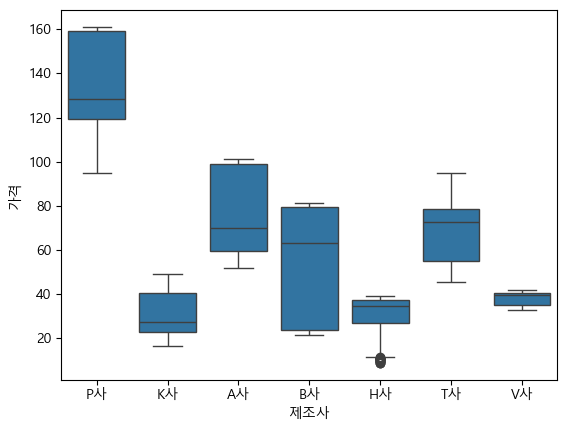

In [477]:
sns.boxplot(  #제조사별 가격 확인
    data=train,
    x='제조사',
    y='가격',
);

<Axes: >

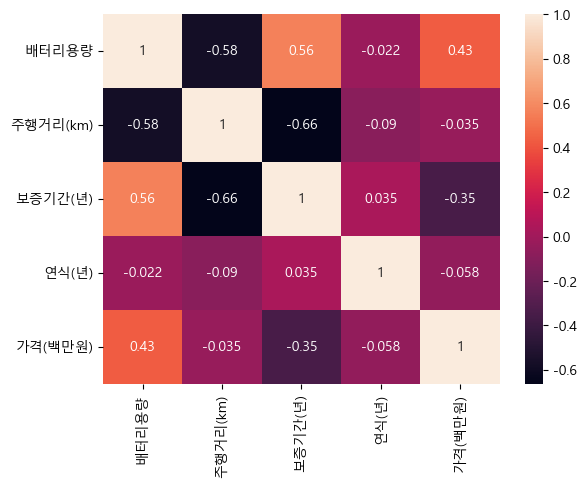

In [469]:
numcor = train[train_show].corr()
plt.Figure(figsize=(20,20))
sns.heatmap(numcor, annot=True) # 배터리용량에는 보증기간과 가격이 가장..


In [478]:
train.groupby(['모델','구동방식'])['가격'].mean().reset_index()  #모델별 구동방식별 가격의 평균이 궁금해서

,모델,구동방식,가격
0,EV6,AWD,44.107094
1,EV6,FWD,44.246786
2,ID4,AWD,38.411702
3,ION5,AWD,35.070142
4,ION6,AWD,38.104855
5,IONIQ,FWD,17.991500
6,KNE,FWD,25.736603
7,M3,RWD,51.632867
8,MS,AWD,74.538195
9,MX,AWD,83.045455


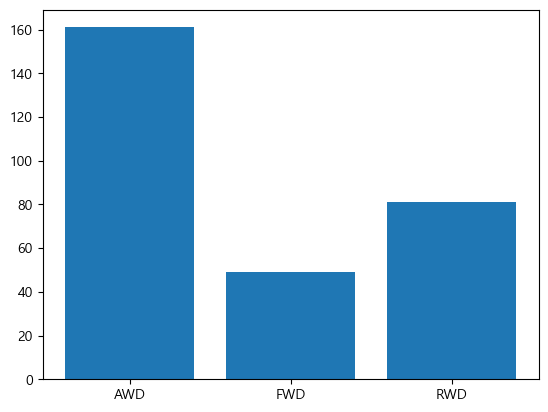

In [479]:
plt.show
plt.bar(train['구동방식'],train['가격'])
plt.show()

모델 별 보증기간의 배터리 용량의 평균으로 결측치를 채우자 !

In [480]:
#atrain = train.groupby(['모델','구동방식'])['배터리용량'].mean().reset_index()  #이전 시도
atrain = train.groupby(['모델','보증기간'])['배터리용량'].mean().reset_index()  

In [481]:
nullhavetrain = train[train['배터리용량'].isnull()]     #병합 쉽게 하기 위해서 
donhavenulltrain = train[train['배터리용량'].notnull()]

In [482]:
#nullhavet = nullhavetrain.merge(atrain,on=['모델','구동방식'],how='left')
nullhavet = nullhavetrain.merge(atrain,on=['모델','보증기간'],how='left')

In [483]:
nullhavet['배터리용량_y'].isnull().sum()  #결측치 존재 .

15

In [484]:
nullhavet[nullhavet['배터리용량_y'].isnull()]  #T사의 mx 모델이로 동일하기때문에 fillna 사용해서 채워주기

,ID,제조사,모델,차량상태,배터리용량_x,구동방식,주행거리,보증기간,사고이력,연식,가격,배터리용량_y
8,TRAIN_0022,T사,MX,Nearly New,NaN,AWD,33126,4,No,0,93.66,NaN
157,TRAIN_0432,T사,MX,Nearly New,NaN,AWD,43648,4,No,0,93.81,NaN
354,TRAIN_0974,T사,MX,Nearly New,NaN,AWD,17277,4,No,0,93.82,NaN
432,TRAIN_1184,T사,MX,Nearly New,NaN,AWD,21670,4,No,0,92.60,NaN
517,TRAIN_1426,T사,MX,Nearly New,NaN,AWD,18615,4,No,0,93.84,NaN
626,TRAIN_1745,T사,MX,Nearly New,NaN,AWD,34099,4,No,0,94.30,NaN
787,TRAIN_2166,T사,MX,Nearly New,NaN,AWD,36184,4,No,0,94.62,NaN
1521,TRAIN_4262,T사,MX,Nearly New,NaN,AWD,29549,4,No,0,92.91,NaN
1532,TRAIN_4297,T사,MX,Nearly New,NaN,AWD,28303,4,No,0,94.20,NaN
1609,TRAIN_4528,T사,MX,Nearly New,NaN,AWD,16767,4,No,0,93.12,NaN


In [485]:
train.groupby('모델')['배터리용량'].mean().reset_index() #90.03

,모델,배터리용량
0,EV6,90.000000
1,ID4,65.424440
2,ION5,66.439545
3,ION6,65.876923
4,IONIQ,62.044352
5,KNE,72.117597
6,M3,64.482882
7,MS,89.672213
8,MX,90.031151
9,MY,63.916380


In [486]:
nullhavet['배터리용량_y'] = nullhavet['배터리용량_y'].fillna(90.03)

In [487]:
del nullhavet['배터리용량_x']  #필요없는 열 삭제

In [488]:
nullhavet.isnull().sum()  #결측치없음

ID         0
제조사        0
모델         0
차량상태       0
구동방식       0
주행거리       0
보증기간       0
사고이력       0
연식         0
가격         0
배터리용량_y    0
dtype: int64

In [489]:
nullhavet = nullhavet.rename(columns={'배터리용량_y':'배터리용량'})

In [490]:
tt = pd.concat([nullhavet,donhavenulltrain])

In [491]:
tt.info()  #결측치 확인 (없음음)

<class 'pandas.core.frame.DataFrame'>
Index: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      7497 non-null   object 
 1   제조사     7497 non-null   object 
 2   모델      7497 non-null   object 
 3   차량상태    7497 non-null   object 
 4   구동방식    7497 non-null   object 
 5   주행거리    7497 non-null   int64  
 6   보증기간    7497 non-null   int64  
 7   사고이력    7497 non-null   object 
 8   연식      7497 non-null   int64  
 9   가격      7497 non-null   float64
 10  배터리용량   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 702.8+ KB


In [125]:
#추후 분석을 하기 위해서 저장
tt.to_csv('mtrain.csv',index=False)

In [492]:
#test데이터도 동일하게
nullhavttest = test[test['배터리용량'].isnull()]
donthavttest = test[test['배터리용량'].notnull()]
nullhavttest = nullhavttest.merge(atrain,on=['모델','보증기간'],how='left')

In [493]:
nullhavttest['배터리용량_y'].isnull().sum()  #결측치 하나 존재

1

In [494]:
nullhavttest[nullhavttest['배터리용량_y'].isnull()]  #동일한 T사의 mx모델

,ID,제조사,모델,차량상태,배터리용량_x,구동방식,주행거리,보증기간,사고이력,연식,배터리용량_y
146,TEST_397,T사,MX,Nearly New,NaN,AWD,13832,4,No,0,NaN


In [495]:
nullhavttest['배터리용량_y'] = nullhavttest['배터리용량_y'].fillna(90.03)

In [496]:
nullhavttest['배터리용량_y'].isnull().sum()  #이제 없음

0

In [497]:
del nullhavttest['배터리용량_x']  #필요없는 열 삭제

In [498]:
nullhavttest = nullhavttest.rename(columns={'배터리용량_y':'배터리용량'})  #이름변경

In [499]:
nullhavttest

,ID,제조사,모델,차량상태,구동방식,주행거리,보증기간,사고이력,연식,배터리용량
0,TEST_002,B사,i5,Brand New,RWD,7197,7,Yes,0,90.000000
1,TEST_004,K사,EV6,Brand New,FWD,7597,10,No,0,90.000000
2,TEST_005,P사,Tay,Brand New,AWD,6836,2,No,0,66.033435
3,TEST_006,H사,KNE,Brand New,FWD,474,10,No,0,90.000000
4,TEST_007,V사,ID4,Brand New,AWD,852,8,No,0,90.000000
...,...,...,...,...,...,...,...,...,...,...
299,TEST_816,K사,Niro,Brand New,FWD,1135,9,No,0,90.000000
300,TEST_819,A사,RSeTGT,Brand New,AWD,9349,8,No,0,90.000000
301,TEST_833,H사,ION5,Brand New,AWD,7578,9,No,0,90.000000
302,TEST_835,B사,iX,Brand New,RWD,8860,8,No,0,90.000000


In [500]:
ttest = pd.concat([nullhavttest,donthavttest])

In [503]:
ttest.shape

(846, 10)

In [504]:
ttest = ttest.sort_values(by=['ID'])  #순서대로

In [188]:
# 저장
ttest.to_csv('mtest.csv',index=False)

----------------------------------------------------

In [5]:
train = pd.read_csv('mtrain.csv')

In [6]:
test = pd.read_csv('mtest.csv')

In [544]:
#모델별, 구동방식별, 차량상태별,제조사별로 모델을 돌려봤지만 오차가 너무 심했음 --> 추가적인 변수들을 넣어주면 RMSE가 감소함

In [515]:
train.groupby(['제조사','모델']).value_counts()  #-->일반적으로는 Brand New이고 주행거리가 짧으면 가격이 더 비쌀거같은데 .. 안그러네

제조사  모델    ID          차량상태        구동방식  주행거리    보증기간  사고이력  연식  가격     배터리용량 
A사   Q4eT  TRAIN_0009  Brand New   AWD   3683    7     No    0   59.66  90.000    1
           TRAIN_0034  Pre-Owned   AWD   59324   0     No    0   55.44  56.788    1
           TRAIN_0041  Nearly New  AWD   38960   5     No    1   57.27  72.548    1
           TRAIN_0069  Pre-Owned   AWD   84938   0     No    0   55.99  59.154    1
           TRAIN_0118  Nearly New  AWD   21017   3     No    0   58.49  66.861    1
                                                                                 ..
V사   ID4   TRAIN_7461  Pre-Owned   AWD   114230  1     No    0   40.25  57.861    1
           TRAIN_7464  Nearly New  AWD   29039   3     No    0   41.34  62.784    1
           TRAIN_7474  Brand New   AWD   9369    7     No    0   33.63  90.000    1
           TRAIN_7481  Nearly New  AWD   20707   3     No    0   40.87  62.784    1
           TRAIN_7485  Nearly New  AWD   30646   5     No    1   41.65  68.125   

<Axes: xlabel='차량상태', ylabel='가격'>

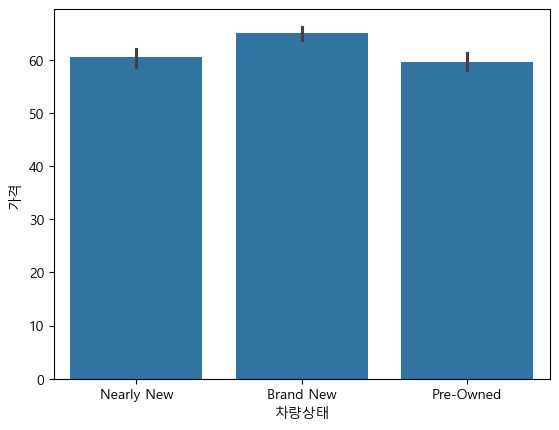

In [516]:
sns.barplot(
    data = train,
    x='차량상태',
    y = '가격'
)

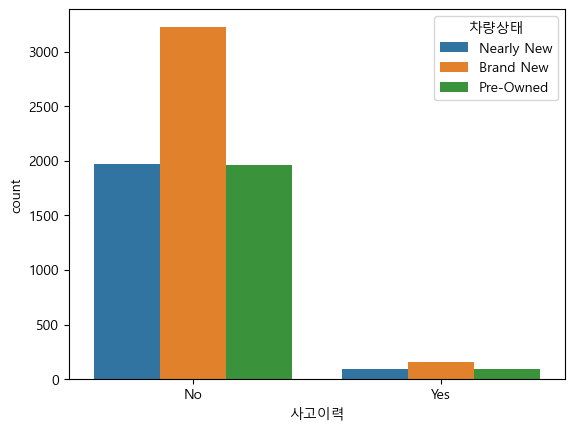

In [517]:
sns.countplot(
    data=train, 

    x='사고이력', 
    hue='차량상태',
     

    );

In [518]:
train.groupby(['사고이력'])['가격'].value_counts()  #사고이력은 가격에 영향을 주지 않는거 같은데

사고이력  가격    
No    60.00     44
      160.00    44
      100.00    42
      39.00     38
      24.00     36
                ..
Yes   160.48     1
      160.57     1
      160.62     1
      160.72     1
      160.87     1
Name: count, Length: 4167, dtype: int64

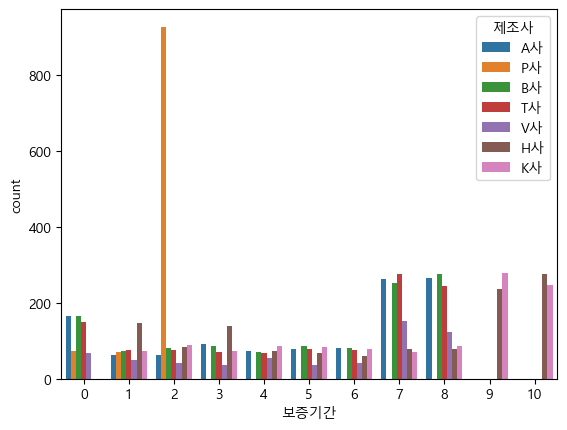

In [519]:
sns.countplot(
    data=train, 

    x='보증기간', 
    hue='제조사',
     

    );

-------------------

In [545]:
tt = train.drop(columns=['ID','제조사','모델'])  #상관관계확인

In [546]:
tt = pd.get_dummies(tt)
a = tt.select_dtypes(include=bool).columns
tt[a] = tt[a].astype(int)

<Axes: >

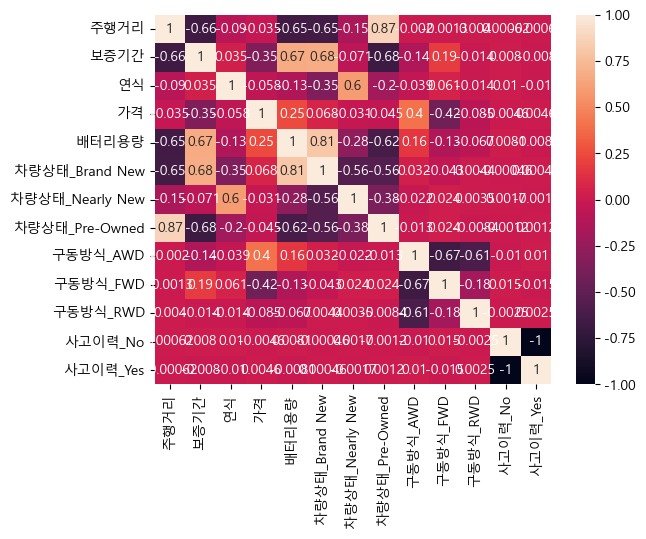

In [547]:
numcor = tt.corr()
plt.Figure(figsize=(30,20))
sns.heatmap(numcor, annot=True) # 

In [610]:
train.head(2)  #위의 내용으로 사고이력은 별 필요 없어 보임!

,ID,제조사,모델,차량상태,구동방식,주행거리,보증기간,사고이력,연식,가격,배터리용량
0,TRAIN_0003,A사,RSeTGT,Nearly New,AWD,21683,3,No,0,99.16,78.227
1,TRAIN_0006,T사,MS,Nearly New,AWD,19395,3,No,0,83.42,81.537


In [8]:
del train['사고이력'] #필요없는 열 삭제 [ID,사고이력]

In [10]:
train = pd.get_dummies(train)
a = train.select_dtypes(include=bool).columns
train[a] = train[a].astype(int)

In [9]:
train.head()

,제조사,모델,차량상태,구동방식,주행거리,보증기간,연식,가격,배터리용량
0,A사,RSeTGT,Nearly New,AWD,21683,3,0,99.16,78.227
1,T사,MS,Nearly New,AWD,19395,3,0,83.42,81.537
2,T사,MY,Brand New,AWD,2226,8,0,74.06,90.000
3,A사,Q4eT,Brand New,AWD,3683,7,0,59.66,90.000
4,V사,ID4,Brand New,AWD,1131,8,0,40.50,90.000


In [11]:
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
kmeans = KMeans(n_clusters=5)
kmeans.fit(train.drop(columns='가격'))


KMeans(n_clusters=5)

In [12]:
clusters = kmeans.labels_
train['클러'] = pd.DataFrame(clusters)

In [13]:
train.shape

(7497, 40)

In [14]:
#test도 동일하게
test = test[['제조사', '모델', '차량상태', '구동방식', '주행거리', '보증기간', '연식','배터리용량']]
test = pd.get_dummies(test)
a = test.select_dtypes(include=bool).columns
test[a] = test[a].astype(int)

In [15]:
cc = kmeans.predict(test)
test['클러'] = pd.DataFrame(cc)

In [16]:
test.shape

(846, 39)

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled = scaler.fit_transform(train[['주행거리','보증기간','연식','배터리용량']])
train[['주행거리','보증기간','연식','배터리용량']] = scaled

In [ ]:
# from sklearn.preprocessing import RobustScaler   # 주행거리가 이상치가 많다고 생각해 찾아본 알고리즘 (이상치에강하다고함)
# scaler = RobustScaler()

# scaled = scaler.fit_transform(tt[['주행거리','보증기간','연식','배터리용량']])
# tt[['주행거리_s','보증기간_s','연식_s','배터리용량_s']] = scaled

In [18]:
test_scal = scaler.transform(test[['주행거리','보증기간','연식','배터리용량']])  #테스트도 동일하게게
test[['주행거리','보증기간','연식','배터리용량']] = test_scal

In [161]:
#ta = train.groupby(['구동방식','차량상태'])['가격'].mean().reset_index() 추가적으로 변수를 넣어보고 싶어서 만들어본것.
#ta = ta.rename(columns={'가격':'구동별차랑별가격'})
#train = train.merge(ta,on=['구동방식','차량상태'],how='left')
#train['비율'] = train['주행거리'] / train['배터리용량']

In [554]:
# test = test.merge(train,on=['구동방식','차량상태'],how='left')      #train도 추가했으면 test도 동일하게 넣어주기.
# test['비율'] = test['주행거리'] / ttest['배터리용량'] 

In [411]:
# train['주행배터리'] = train['주행거리_s'] * train['배터리용량_s']  #특성공학처럼...
# train['주행제곱'] = train['주행거리_s']**2
# train['배터리리제곱'] = train['배터리용량_s']**2

In [431]:
# ttest['주행배터리'] = ttest['주행거리_s'] * ttest['배터리용량_s']
# ttest['주행제곱'] = ttest['주행거리_s']**2
# ttest['배터리리제곱'] = ttest['배터리용량_s']**2

In [19]:
y = train['가격']
x= train.drop(columns='가격')

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [21]:
lgbr = LGBMRegressor(n_estimators=100, max_depth=-1, random_state=42)  #이거 -1이면 제한 안거는거
lgbr.fit(x_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 447
[LightGBM] [Info] Number of data points in the train set: 5997, number of used features: 39
[LightGBM] [Info] Start training from score 62.102790


LGBMRegressor(random_state=42)

In [24]:
print(lgbr.score(x_train,y_train))
print(lgbr.score(x_test,y_test))
y_pred = lgbr.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("테스트 데이터 RMSE:", mse**0.5)

0.9989950045555664
0.9988034051351524
테스트 데이터 RMSE: 1.3130593030925923


In [25]:
model =XGBRegressor(n_estimators=50, random_state=42)
model.fit(x_train,y_train)
print(model.score(x_train,y_train))
print(model.score(x_test,y_test))
y_pred = model.predict(x_test)

mse = mean_squared_error(y_test, y_pred)
print("테스트 데이터 RMSE:", mse**0.5)


0.9993134284449537
0.9987824566986933
테스트 데이터 RMSE: 1.3245031072355313


In [31]:
pred = lgbr.predict(test)   #LGBM

In [30]:
pred = model.predict(test) #XGB

In [32]:
sub = pd.read_csv('Dcon/open/sample_submission.csv')
am = pd.DataFrame(pred)

In [33]:
am  #확인

,0
0,130.704395
1,80.036914
2,64.777347
3,34.766510
4,47.847702
...,...
841,151.285769
842,38.863998
843,38.785348
844,58.735644


In [38]:
sub['가격(백만원)'] = am

In [39]:
sub

,ID,가격(백만원)
0,TEST_000,130.704395
1,TEST_001,80.036914
2,TEST_002,64.777347
3,TEST_003,34.766510
4,TEST_004,47.847702
...,...,...
841,TEST_841,151.285769
842,TEST_842,38.863998
843,TEST_843,38.785348
844,TEST_844,58.735644


In [41]:
sub['가격(백만원)'] = sub['가격(백만원)'].apply(lambda x : round(x,2))

In [42]:
sub

,ID,가격(백만원)
0,TEST_000,130.70
1,TEST_001,80.04
2,TEST_002,64.78
3,TEST_003,34.77
4,TEST_004,47.85
...,...,...
841,TEST_841,151.29
842,TEST_842,38.86
843,TEST_843,38.79
844,TEST_844,58.74


In [43]:
sub.to_csv('51.csv',index=False)